In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import spyglass as nd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from spyglass.common import (Session, IntervalList,LabMember, LabTeam, Raw, Session, Nwbfile,
                            Electrode,LFPBand,interval_list_intersect)
from spyglass.common import TaskEpoch
from spyglass.utils.nwb_helper_fn import get_nwb_copy_filename
import os
os.environ["SPYGLASS_VIDEO_DIR"] = '/stelmo/nwb/video/'
import warnings
warnings.filterwarnings("ignore")

raw_dir = '/stelmo/nwb/raw'
import pynwb

[2025-02-24 15:47:27,271][INFO]: Connecting shijiegu-alt@lmf-db.cin.ucsf.edu:3306
[2025-02-24 15:47:27,356][INFO]: Connected shijiegu-alt@lmf-db.cin.ucsf.edu:3306


In [3]:
from spyglass.common.common_position import IntervalPositionInfo
from spyglass.common.common_position import RawPosition
from spyglass.common.common_position import IntervalLinearizedPosition
from spyglass.shijiegu.Analysis_SGU import TrialChoice

In [4]:
from spyglass.common.common_behav import VideoFile
import cv2 

In [70]:
nwb_file_name = 'eliot20221024.nwb' 
#eliot20221024_.nwb 06_Seq2Session4 pos 5 valid times trial 19

#lewis20240108_.nwb 04_Rev2Session2 pos 3 valid times trial 21
#21 06_Seq2Session3 trial 10
# 21 04_Seq2Session2 trial 47

nwb_copy_file_name = get_nwb_copy_filename(nwb_file_name)

## Pick a session

In [71]:
epochInd = 6;
trialInd = 19;

In [72]:
key={'nwb_file_name':nwb_copy_file_name,'epoch':epochInd}
print(TrialChoice & key)
log=(TrialChoice & key).fetch1('choice_reward')
log_df=pd.DataFrame(log)

*nwb_file_name *epoch    epoch_name     choice_rew
+------------+ +-------+ +------------+ +--------+
eliot20221024_ 6         06_Seq2Session =BLOB=    
 (Total: 1)



In [73]:
TaskEpoch & {'nwb_file_name': nwb_copy_file_name,'epoch':epochInd}

nwb_file_name name of the NWB file,epoch the session epoch for this task and apparatus(1 based),task_name,camera_name,interval_list_name descriptive name of this interval list,task_environment the environment the animal was in,camera_names list of keys corresponding to entry in CameraDevice
eliot20221024_.nwb,6,maze,maze_camera,06_Seq2Session4,none,=BLOB=


In [74]:
VideoFile & {'nwb_file_name': nwb_copy_file_name}

nwb_file_name name of the NWB file,epoch the session epoch for this task and apparatus(1 based),video_file_num,camera_name,video_file_object_id the object id of the file object
eliot20221024_.nwb,1,0,,0e93270b-0fd8-48ec-8e01-9b5f959f2c8e
eliot20221024_.nwb,2,0,,ed40fe6e-8998-4aae-a9be-c068f15ec6a2
eliot20221024_.nwb,3,0,,b879389c-dbba-445c-887d-1c17c5e2d21a
eliot20221024_.nwb,4,0,,53314f96-07b1-4da4-b01f-9d55f497e7de
eliot20221024_.nwb,5,0,,4a91efc7-9f8b-4566-824f-b8d4b31dcf34
eliot20221024_.nwb,6,0,,1ee24d1f-672e-406a-ac79-eb5e27b30baa
eliot20221024_.nwb,7,0,,00030c58-be32-4316-84f8-188377a2e074
eliot20221024_.nwb,8,0,,bb470ad2-8179-4949-9b0a-a0661b2c1f5f
eliot20221024_.nwb,9,0,,9773671c-0740-4707-bc6d-69a774ca01d3
eliot20221024_.nwb,10,0,,14bcd394-f0e2-4ea8-8983-799eeca6ed27


### Load Video and its TimeStamp

In [75]:
key = {'nwb_file_name': nwb_copy_file_name,'epoch':epochInd}

# video path
videoPath = VideoFile.get_abs_path(key)
video_info = (VideoFile & key).fetch1()

# parent underscore version nwb path
nwb_path = f"{raw_dir}/{video_info['nwb_file_name']}"

# load video timestamp from parent underscore version nwb
with pynwb.NWBHDF5IO(path=nwb_path, mode="r") as in_out:
    nwb_file = in_out.read()
    nwb_video = nwb_file.objects[video_info["video_file_object_id"]]
    video_filepath = VideoFile.get_abs_path(
        {"nwb_file_name": key["nwb_file_name"], "epoch": key["epoch"]}
    )
    video_dir = os.path.dirname(video_filepath) + "/"
    video_filename = video_filepath.split(video_dir)[-1]
    meters_per_pixel = nwb_video.device.meters_per_pixel
    timestamps = np.asarray(nwb_video.timestamps)

# load video
cap = cv2.VideoCapture(video_dir+video_filename)


In [76]:
print

<function print>

### Make Video

In [77]:
t0 = log_df.loc[trialInd,'timestamp_H']
t1 = log_df.loc[trialInd + 1,'timestamp_H']
if np.isnan(t0):
    t0 = t1-12


frameToPlot = np.argwhere(np.logical_and(timestamps>=t0,timestamps<=t1)).ravel()
frame0 = frameToPlot[0]
frameLast = frameToPlot[-1]

fps = cap.get(cv2.CAP_PROP_FPS) # Gets the frames per second
frameSize = (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))

fourcc = cv2.VideoWriter_fourcc(*'MP4V')
outputName = nwb_copy_file_name + (TrialChoice & key).fetch1('epoch_name') + 'trial'+str(trialInd);
out = cv2.VideoWriter(outputName+'.mp4', fourcc, fps, frameSize)

for fi in range(len(timestamps)):##len(frameToPlot)):
    ret, frame = cap.read()
    if fi >= frame0 and fi <= frameLast:
        out.write(frame)
        
cap.release()
out.release()

OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


In [78]:
t1

1666644507.386773

In [22]:
timestamps[-1]

1666044949.2632408

In [382]:
def increase_brightness(img, value=20):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)

    lim = 255 - value
    v[v > lim] = 255
    v[v <= lim] += value

    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return img

In [13]:
ret, frame = cap.read()

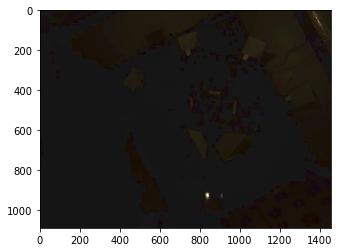

In [383]:
frameBrighter = increase_brightness(frame)
plt.imshow(cv2.cvtColor(frameBrighter, cv2.COLOR_BGR2RGB))

In [213]:
## Make a single frame
videopath = '/cumulus/shijie/recording_pilot/lewis/20240120_151209_Lewis_Rev1_Session4/20240120_151209_Lewis_Rev1_Session4.1.h264'
cap = cv2.VideoCapture(videopath)

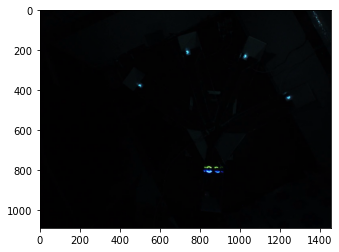

In [214]:
minuteMark = 20;
for fi in range(minuteMark*29*60):##len(frameToPlot)):
    ret, frame = cap.read()
    if fi > minuteMark*29*60-2:
        plt.imshow(frame)
        break

In [368]:
for i in range(1):
    ret, frame = cap.read()
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

error: OpenCV(4.5.5) /home/conda/feedstock_root/build_artifacts/libopencv_1650899540458/work/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


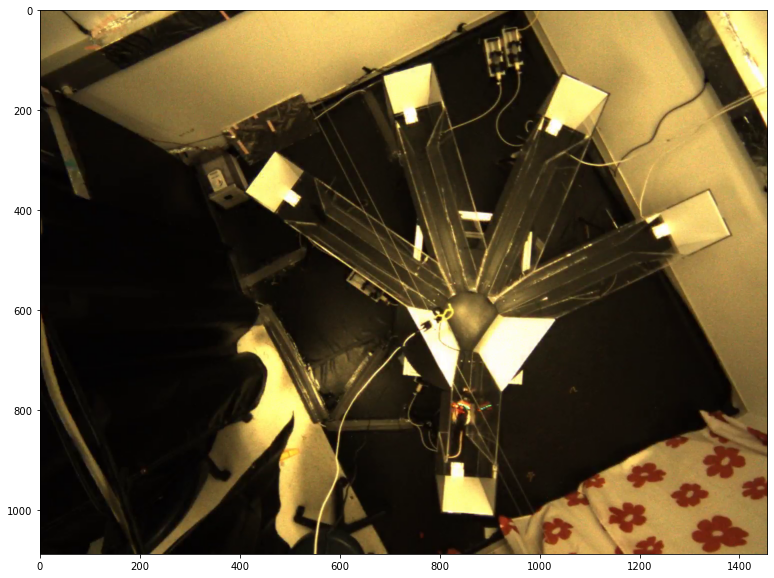

In [345]:
fig,axes=plt.subplots(1,1,figsize=(20, 10))
axes.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.savefig('maze_overView.png',bbox_inches='tight',dpi=500)

In [ ]:
'''
for fi in [0]:#range(len(frameToPlot)):
    ret, frame = cap.read()
    my_video_name = video_filename.split(".")[0]
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))